# Polymer data

Huan Tran, Georgia Institute of Technology, huan.tran@mse.gatech.edu

This notebook provides scripts used to train four datasets provided by Polymer Genome (PG, https://www.polymergenome.org/), including the (DFT) HSE band gap, the (electronic and ionic) dielectric constants, and the atomization energy of about 380 organic polymers. Polymers crystals in each dataset were fingerprinted at 3 levels of atomic-level fingerprints, i.e., singles, doubles, and triples (from lower to higher length scales). Three fingerprinted datasets are then named as "**fp_aS.csv**", "**fp_aD.csv**", and "**fp_aT.csv**". Given the nature of the physical properties demonstrated here, these atomic-level fingerprints (described below) are sufficient, no need to go use fingerprints of longer length scales. Data files are in csv format in which each polymer is in a line. The *first column* is for polymer id, the *next four columns* are for atomization energy, band gap, electronic, and ionic dielectric constants, and the *remaining columns* are for fingerprints.  

Details on the data curation are given in *[Huan et el, Sci. Data **3**, 160012 (2016)]*. This includes how to get polymers crystal structures, what level of DFT used for computations, to what extent the data is validated, and so on. The atomic fragment-based fingerprints are described in *[Huan et al., Phys. Rev. B **92**, 014106 (2015)]*, in which the motivation, the definition, and the relations of the fingerprints are described. In short, these fingerprints capture how many fragments of a given type that show up in the polymer. In the figure below, C2 is **a single**, representing a C atom with two bonds, and O2 is another **single** representing an O atom with two bonds. A **double** or **triple** contains two or three singles in a given order. From the chemistry, more information can be readily extracted. For example, two bonds of a C2 must be double bonds while for C3, two are single bonds and the other is a double bond. 

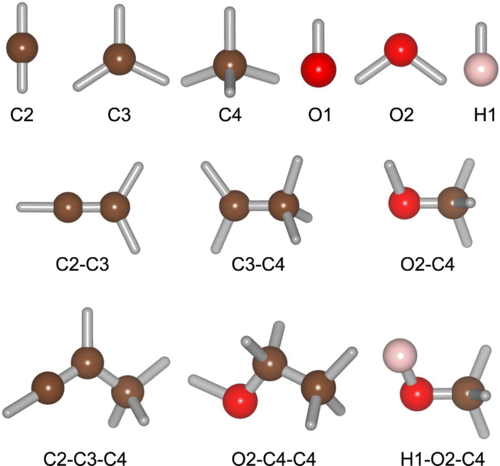

The scripts provided below will train the Gaussian Process Regression (GPR) models on the provided data. GPR is used in PG for some reasons, i.e., it is quite intuitive and a measure of uncertainty can be obtained. One needs to update the data file name in this notebook to make the model of interest. In general, it is expected that models based on higher levels of atomic fingerprints will be better than those based on lower levels. 

Materials used for this hackathon are the results of some polymer-related projects pursued in our research group, led by Prof. Rampi Ramprasad at Georgia Institute of Technology. Of these projects, Polymer Genome aims at developing an informatics platform for polymers predictions and design. Data, the most essential component of PG, is currently in a significantly expanding phase with supports from Toyota Research Institute.  

*NOTICE:  All information contained herein is, and remains the property of Georgia Tech Research Corporation and its sponsors, if any.  The intellectual and technical concepts contained herein are proprietary to Georgia Tech Research Corporation and its sponsors and may be covered by U.S. and Foreign Patents, patents in process, and are protected by trade secret or copyright law. Dissemination of this information or reproduction of this material is strictly forbidden unless prior written permission is obtained from Georgia Tech Research Corporation.*

In [1]:
# Some necessary modules are loaded
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

In [2]:
# Reading data from the data file
%%shell
#This is the data
gdown https://drive.google.com/uc?id=1FQansGEe9ZhSK6iSgrHFuC6fO_BCKUV8

df   = pd.read_csv('fp_aT.csv', delimiter=',', header=0)
data_tot = np.array(df)

# Select property 
prop_sel = "atomization energy"

if prop_sel == "band gap":
    data_sel = np.delete(data_tot,[0,2,3,4],axis=1)
elif prop_sel == "atomization energy":     
    data_sel = np.delete(data_tot,[0,1,3,4],axis=1)
elif prop_sel == "electronic dielectric":     
    data_sel = np.delete(data_tot,[0,1,2,4],axis=1)
elif prop_sel == "ionic dielectric":     
    data_sel = np.delete(data_tot,[0,1,2,3],axis=1)    

# Remove NaN data    
data_sel_nonan = data_sel[~np.isnan(data_sel).any(axis=1)]

# X (fingerprint) and Y (property) of the polymers 
X = data_sel_nonan[:,1:]
Y = data_sel_nonan[:,0]

#print (np.shape(data_sel))
#print (np.shape(data_sel_nonan))

In [3]:
# Split the data into training and test sets
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state=1)

In [4]:
# Some initial parameters to determine the hyperparameters 
Y_average = np.average(Y)
noise_avr = np.std(Y)
noise_lb  = noise_avr/10
noise_ub  = noise_avr*10
n_fold    = 5

# The prior of the GPR model
kernel   = (Y_average)**2*RBF(length_scale=1)+WhiteKernel(noise_level=noise_avr**2,noise_level_bounds=(noise_lb**2, noise_ub**2))
gp       = GaussianProcessRegressor(kernel=kernel, alpha=0, n_restarts_optimizer=5)

# Now training the GPR model
opt_gp   = gp
opt_rmse = 1.0E20
ncv      = 0
ncv_opt  = ncv

# Training set splitted into n_fold subsets
kf_      = KFold(n_splits=n_fold, shuffle = True)
kf       = kf_.split(Y_train)

# Loop for the best kernal
for train, test in kf:
    X_cv_train = X_train[train]
    X_cv_test  = X_train[test]
    Y_cv_train = Y_train[train]
    Y_cv_test  = Y_train[test]
    
    gp         = GaussianProcessRegressor(kernel=kernel, alpha=0, n_restarts_optimizer=10)
    gp.fit(X_cv_train, Y_cv_train)
    y_cv_train = gp.predict(X_cv_train, return_std=False) 
    y_cv_test  = gp.predict(X_cv_test, return_std=False)  

    rmse_cv_train = np.sqrt(mean_squared_error(Y_cv_train, y_cv_train))
    rmse_cv_test  = np.sqrt(mean_squared_error(Y_cv_test, y_cv_test))
    print('        ncv, rmse_train, rmse_test: ', ncv, rmse_cv_train, rmse_cv_test)

    if rmse_cv_test < opt_rmse:
        opt_rmse = rmse_cv_test
        opt_gp   = gp
        ncv_opt  = ncv

    ncv = ncv + 1

print('        Optimal ncv: ', ncv_opt, "; optimal kernel saved.")

        ncv, rmse_train, rmse_test:  0 0.015536410369025703 0.022975812635230623
        ncv, rmse_train, rmse_test:  1 0.016010447851705564 0.030980169360556538
        ncv, rmse_train, rmse_test:  2 0.015028913694818404 0.027922096287775942
        ncv, rmse_train, rmse_test:  3 0.015916415213117683 0.04275439088041474
        ncv, rmse_train, rmse_test:  4 0.015676625098687568 0.04683045348900068
        Optimal ncv:  0 ; optimal kernel saved.


In [5]:
# Come back to the initial training and sets 
X_train_final = X_train
X_test_final  = X_test

# Take the optimal kernel (hyperparameters) to "train" the model on the initial training set 
gp_final      = GaussianProcessRegressor(kernel=opt_gp.kernel_, alpha=0, optimizer=None)
gp_final.fit(X_train_final, Y_train)

# Make predictions
y_train    = gp_final.predict(X_train_final, return_std=False)
y_test     = gp_final.predict(X_test_final,  return_std=False)

# Error measures
rmse_train = np.sqrt(mean_squared_error(Y_train, y_train))
rmse_test  = np.sqrt(mean_squared_error(Y_test, y_test))
R2_train_  = gp_final.score(X_train_final, Y_train)
R2_test_   = gp_final.score(X_test_final, Y_test)

# Three optimal hyperparameters can be obtained by the following lines
#print ("k1.k1.constant_value = " + str(gp_final.kernel_.k1.k1.constant_value))
#print ("k2.noise_level       = " + str(gp_final.kernel_.k2.noise_level))
#print ("k2.k2.length_scale   = " + str(gp_final.kernel_.k1.k2.length_scale))

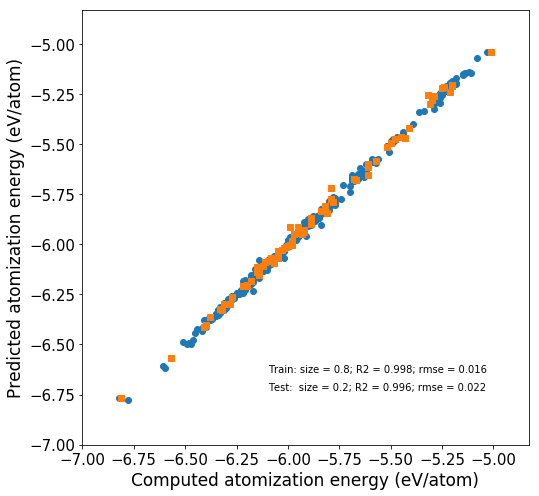

In [7]:
# Visualize the prediction
import matplotlib.pyplot as plt

train_size  = 1.0-test_size
label_train = 'Train: size = ' + str(train_size) +'; R2 = ' + str('%.3f' % R2_train_) + '; rmse = ' + str(
    '%.3f' % rmse_train)
label_test  = 'Test:  size = ' + str(test_size) + '; R2 = ' + str('%.3f' % R2_test_) + '; rmse = ' + str(
    '%.3f' % rmse_test)

plt.figure(figsize=(8, 8))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

lim_min = min(min(Y_train), min(Y_test), min(y_train), min(y_test))     
lim_max = max(max(Y_train), max(Y_test), max(y_train), max(y_test))
lim = [lim_min - (lim_max - lim_min) * 0.1, lim_max + (lim_max - lim_min) * 0.1]
plt.xlim(lim)
plt.ylim(lim)

plt.text(lim_min + (lim_max - lim_min) * 0.4, lim_min + (lim_max - lim_min) * 0.1, label_train)
plt.text(lim_min + (lim_max - lim_min) * 0.4, lim_min + (lim_max - lim_min) * 0.05, label_test)

if prop_sel == "band gap":
    plt.xlabel("Computed band gap (eV)", size=17)
    plt.ylabel("Predicted band gap (eV)", size=17)
elif prop_sel == "atomization energy":     
    plt.xlabel("Computed atomization energy (eV/atom)", size=17)
    plt.ylabel("Predicted atomization energy (eV/atom)", size=17)
elif prop_sel == "electronic dielectric":     
    plt.xlabel("Computed electronic dielectric constant", size=17)
    plt.ylabel("Predicted electronic dielectric constant", size=17)
elif prop_sel == "ionic dielectric":     
    plt.xlabel("Computed ionic dielectric constant", size=17)
    plt.ylabel("Predicted ionic dielectric constant", size=17)

plots_ = list()
plot_train = plt.scatter(Y_train, y_train, marker='o', label="train set")
plots_.append(plot_train)
plot_test = plt.scatter(Y_test, y_test, marker='s', label="test set")
plots_.append(plot_test)